# <img style="float: left; padding-right: 10px; width: 45px" src="https://raw.githubusercontent.com/Harvard-IACS/2018-CS109A/master/content/styles/iacs.png"> CS109B Data Science 2: Advanced Topics in Data Science 
## Homework 4 - RNN



**Harvard University**<br/>
**Spring 2019**<br/>
**Instructors**: Mark Glickman and Pavlos Protopapas 


<hr style="height:2pt">

In [1]:
#RUN THIS CELL 
import requests
from IPython.core.display import HTML
styles = requests.get("https://raw.githubusercontent.com/Harvard-IACS/2018-CS109A/master/content/styles/cs109.css").text
HTML(styles)

### INSTRUCTIONS

<span style="color:red">**Model training can be very slow; start doing this HW early**</span>

- To submit your assignment follow the instructions given in Canvas.

- This homework can be submitted in pairs.

- If you submit individually but you have worked with someone, please include the name of your **one** partner below.
- Please restart the kernel and run the entire notebook again before you submit.

**Names of person you have worked with goes here:**
<br><BR>

<div class="theme"> Overview: Named Entity Recognition Challenge</div>

Named entity recognition (NER) seeks to locate and classify named entities present in unstructured text into predefined categories such as organizations, locations, expressions of times, names of persons, etc. This technique is often used in real use cases such as classifying content for news providers, efficient search algorithms over large corpora and content-based recommendation systems. 

This represents an interesting "many-to-many" problem, allowing us to experiment with recurrent architectures and compare their performances against other models.


In [2]:
import pandas as pd
import numpy as np

from sklearn.metrics import f1_score, confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA


import matplotlib.pyplot as plt
plt.style.use("ggplot")


In [3]:
import keras
import tensorflow as tf

from keras.preprocessing.sequence import pad_sequences
from keras.utils import to_categorical,np_utils
from keras import backend

from keras.models import Model, Input, Sequential,model_from_json
from keras.layers import SimpleRNN, Embedding, Dense, TimeDistributed, GRU, \
                         Dropout, Bidirectional, Conv1D, BatchNormalization

print(keras.__version__)
print(tf.__version__)

Using TensorFlow backend.


2.2.4
1.12.0


In [4]:
# Set seed for repeatable results
np.random.seed(123)
tf.set_random_seed(456)

<div class='explication'> </div>


## Part 1: Read the data

Read in data ```HW4_data.csv``` and use the  code below to open the csv as a pandas dataframe.

As you can see, we have a dataset with sentences (```Sentence #``` column), each composed of words (```Word``` column) with part-of-speech tagging (```POS``` tagging) and inside–outside–beginning (IOB) named entity tags (```Tag``` column) attached. ```POS``` will not be used for this homework. We will predict ```Tag``` using only the words themselves.

Essential info about entities:
* geo = Geographical Entity
* org = Organization
* per = Person
* gpe = Geopolitical Entity
* tim = Time indicator
* art = Artifact
* eve = Event
* nat = Natural Phenomenon

IOB prefix:
* B: beginning of named entity
* I: inside of named entity
* O: outside of named entity

In [5]:
# Given code
path_dataset = './data/HW4_data.csv'
data = pd.read_csv(path_dataset, encoding="latin1")
data = data.fillna(method="ffill")
data.head(15)

,Sentence #,Word,POS,Tag
0,Sentence: 1,Thousands,NNS,O
1,Sentence: 1,of,IN,O
2,Sentence: 1,demonstrators,NNS,O
3,Sentence: 1,have,VBP,O
4,Sentence: 1,marched,VBN,O
5,Sentence: 1,through,IN,O
6,Sentence: 1,London,NNP,B-geo
7,Sentence: 1,to,TO,O
8,Sentence: 1,protest,VB,O
9,Sentence: 1,the,DT,O


<div class='exercise'><b> Question 1.  Prepare Data [20pt]</b></div>


<span class='sub-q'> **Question 1.1**</span> 
* (1) Create a list of unique words found in column 'Word'
* (2) Sort the list in alphabetic order
* (3) Append the special word "ENDPAD" to the end of the list, and store it to a variable ```words```
* (4) Store the length of this list to a variable ```n_words```

<div class='explication'> </div>

In [6]:
# Count number of words
words = sorted(list(set(data["Word"].values)))
words.append("ENDPAD")
n_words = len(words)

In [7]:
n_words

35179

<span class='sub-q'>**Question 1.2**</span>
* (1) Store a list of unique tags into a variable ```tags```, paying attention to sort the list in alphabetic order
* (2) Append the special tag "PAD" to the end of the list
* (3) Store the length of this list to a variable ```n_tags```

<div class='explication'> </div>

In [7]:
# Count number of tags
tags = sorted(list(set(data["Tag"].values)))
tags.append('PAD')
n_tags = len(tags)

In [9]:
n_tags

18

<span class='sub-q'>**Question 1.3**</span>
* (1) Process data into a list of sentences, each sentence is a list of (word, tag) tuples.

**Example**

First sentence in the list of sentences:

[('Thousands', 'O'),
 ('of',  'O'),
 ('demonstrators', 'O'),
 ('have', 'O'),
 ('marched', 'O'),
 ('through', 'O'),
 ('London', 'B-geo'),
 ('to', 'O'),
 ('protest', 'O'),
 ('the', 'O'),
 ('war', 'O'),
 ('in', 'O'),
 ('Iraq', 'B-geo'),
 ('and', 'O'),
 ('demand', 'O'),
 ('the', 'O'),
 ('withdrawal', 'O'),
 ('of', 'O'),
 ('British', 'B-gpe'),
 ('troops', 'O'),
 ('from', 'O'),
 ('that', 'O'),
 ('country', 'O'),
 ('.', 'O')]
* (2) Find out the number of words in the longest sentence, and store it to variable ```max_len```


<div class='explication'> </div>

In [8]:
# Get maximum sentence length as padding size
agg_func = lambda s: [(w, t) for w, t in zip(s["Word"].values.tolist(),s["Tag"].values.tolist())]
grouped = data.groupby("Sentence #").apply(agg_func)
sentences = [s for s in grouped]

max_len = max([len(s) for s in sentences])

In [11]:
# Run this cell to show your results #
print(max_len)

104


<span class='sub-q'>**Question 1.4**</span>

It's now time to convert the sentences data in a suitable format for the RNNs training/evaluation procedures. To this end, you are required to:
* (1) Create a ```word2idx``` dictionary mapping distinct words from the dataset into distinct integers. Also create a ```idx2word``` dictionary. 
* (2) Prepare the predictors matrix ```X```, as a list of lists, where each inner list is a sequence of words mapped into integers accordly to the ```word2idx``` dictionary. 
* (3) Apply the keras ```pad_sequences``` function to standardize the predictors. You should retrieve a matrix with all padded sentences and length equal to ```max_len``` previously computed. The dimensionality should therefore be equal to ```[# of sentences, max_len]```

Your ```X[i]``` now should be something similar to this:

```[ 8193 27727 31033 33289 22577 33464 23723 16665 33464 31142 31319 28267
 27700 33246 28646 16052    21 16915 17349  7924 32879 32985 18238 23555
    24 35178 35178 35178 35178 35178 35178 35178 35178 35178 35178 35178
 35178 35178 35178 35178 35178 35178 35178 35178 35178 35178 35178 35178
 35178 35178 35178 35178 35178 35178 35178 35178 35178 35178 35178 35178
 35178 35178 35178 35178 35178 35178 35178 35178 35178 35178 35178 35178
 35178 35178 35178 35178 35178 35178 35178 35178 35178 35178 35178 35178
 35178 35178 35178 35178 35178 35178 35178 35178 35178 35178 35178 35178
 35178 35178 35178 35178 35178 35178 35178 35178]```
 
* (4) Create a ```tag2idx``` dictionary mapping distinct named entity tags from the dataset into distinct integers. Also create a ```idx2tag``` dictionary.

* (5) Prepare targets matrix ```Y```, as a list of lists,where each inner list is a sequence of tags mapped into integers accordly to the ```tag2idx``` dictionary.
* (6) apply the keras ```pad_sequences``` function to standardize the targets. Inject the ```PAD``` tag for the padding words. You should retrieve a matrix with all padded sentences'tags and length equal to ```max_length``` previously computed. 

* (7) Use the ```to_categorical``` keras function to one-hot encode the tags.

Now your ```Y``` should have dimension ```[# of sentences, max_len, n_tags]```

* (8) Split the dataset in train and test datasets (test 10%).

<div class='explication'> </div>

In [9]:
# Create dictionary to map words to integers
word2idx = {w: i for i, w in enumerate(words)}
idx2word = {i: w for i, w in enumerate(words)}

# Prepare predictors list of lists
X = [[word2idx[w[0]] for w in s] for s in sentences]
# Apply the keras pad_sequences function
X = pad_sequences(maxlen=max_len, sequences=X, padding="post", value=n_words-1)

In [10]:
# Create dictionary to map tags to integers
tag2idx = {t: i for i, t in enumerate(tags)}
idx2tag = {i: t for i, t in enumerate(tags)}

# Prepare targets list of lists
y = [[tag2idx[w[1]] for w in s] for s in sentences]
# Apply the kera pas_sequences function
y = pad_sequences(maxlen=max_len, sequences=y, padding="post", value=tag2idx["PAD"])

# Onehot encode target variable
y = [to_categorical(i, num_classes=n_tags) for i in y]

In [106]:
# Split train/test datasets
X_tr, X_te, y_tr, y_te = train_test_split(X, y, test_size=0.1, shuffle=True)
y_tr, y_te = np.array(y_tr), np.array(y_te)

In [15]:
# Run this cell to show your results #
print("The index of word 'Harvard' is: {}\n".format(word2idx["Harvard"]))
print("Sentence 1: {}\n".format(X[1]))
print(X.shape)

The index of word 'Harvard' is: 7506

Sentence 1: [ 8193 27727 31033 33289 22577 33464 23723 16665 33464 31142 31319 28267
 27700 33246 28646 16052    21 16915 17349  7924 32879 32985 18238 23555
    24 35178 35178 35178 35178 35178 35178 35178 35178 35178 35178 35178
 35178 35178 35178 35178 35178 35178 35178 35178 35178 35178 35178 35178
 35178 35178 35178 35178 35178 35178 35178 35178 35178 35178 35178 35178
 35178 35178 35178 35178 35178 35178 35178 35178 35178 35178 35178 35178
 35178 35178 35178 35178 35178 35178 35178 35178 35178 35178 35178 35178
 35178 35178 35178 35178 35178 35178 35178 35178 35178 35178 35178 35178
 35178 35178 35178 35178 35178 35178 35178 35178]

(47959, 104)


In [16]:
# Run this cell to show your results #
print("The index of tag 'B-gpe' is: {}\n".format(tag2idx["B-gpe"]))
print("The tag of the last word in Sentence 1: {}\n".format(y[0][-1]))
print(np.array(y).shape)

The index of tag 'B-gpe' is: 3

The tag of the last word in Sentence 1: [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1.]

(47959, 104, 18)


## Part 2: Modelling

After preparing the train and test sets, we are ready to build five models: 
* frequency-based baseline 
* vanilla feedforward neural network
* recurrent neural network
* gated recurrent neural network
* bidirectional gated recurrent neural network

More details are given about architecture in each model's section. The input/output dimensionalities will be the same for all models:
* input: ```[# of sentences, max_len]```
* output: ```[# of sentences, max_len, n_tags]```

Follow the information in each model's section to set up the architecture of each model. And the end of each training, use the given ```store_model``` function to store the weights and architectures in the ```./models``` path for later testing;```load_keras_model()``` is also provided to you

A further ```plot_training_history``` helper function is given in case you need to check the training history.


In [11]:
# Store model
def store_keras_model(model, model_name):
    model_json = model.to_json() # serialize model to JSON
    with open("./models/{}.json".format(model_name), "w") as json_file:
        json_file.write(model_json)
    model.save_weights("./models/{}.h5".format(model_name)) # serialize weights to HDF5
    print("Saved model to disk")
    
# Plot history
def plot_training_history(history):
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    epochs = range(1,len(loss)+1)

    plt.figure()
    plt.plot(epochs, loss, 'bo', label='Training loss')
    plt.plot(epochs, val_loss, 'b', label='Validation loss')
    plt.title('Training and validation loss')
    plt.xlabel('epoch')
    plt.legend()
    plt.show()

In [12]:
# Load model 
def load_keras_model(model_name):
    # Load json and create model
    json_file = open('./models/{}.json'.format(model_name), 'r')
    loaded_model_json = json_file.read()
    json_file.close()
    model = model_from_json(loaded_model_json)
    # Load weights into new model
    model.load_weights("./models/{}.h5".format(model_name))
    return model

<div class='exercise'><b>Question 2: Models [40pt]</b></div>

<span class='sub-q'>**Question 2.1**</span>

### Model 1: Baseline Model ###

Predict the tag of a word simply with the most frequently-seen named entity tag of this word from the training set.

e.g. word "Apple" appears 10 times in the training set; 7 times it was tagged as "Corporate" and 3 times it was tagged as "Fruit". If we encounter the word "Apple" in the test set, we predict it as "Corporate".

**Create an np.array ```baseline``` of length [n_words]**
where the ith element   ```baseline[i]``` is the index of the most commonly seen named entity tag of word i summarised from training set.   (e.g. [16, 16, 16, ..., 0, 16, 16])




<div class='explication'> </div>

In [19]:
# solution # 
class CounterModel:
    
    def __init__(self):
        pass
    
    def fit(self, X_tr, y_tr, n_words, n_tags):
        self.dict_np = np.zeros(shape=(n_words,n_tags))
        for sentence in range(X_tr.shape[0]):
            for word in range(X_tr.shape[1]):
                self.dict_np[X_tr[sentence,word],:] += y_tr[sentence,word,:] 
        unseen_index = np.sum(self.dict_np,axis=1)==0
        self.dict_np = np.argmax(self.dict_np, axis=1)
        self.dict_np[unseen_index]=tag2idx['O']
        
    def predict(self, X_te, batch_size=None):
        return np.array([idx2tag[i] for i in self.dict_np[X_te]])


model = CounterModel()
model.fit(X_tr, y_tr, n_words, n_tags)
model.predict(X[0])

array(['O', 'O', 'O', 'O', 'O', 'O', 'B-geo', 'O', 'O', 'O', 'O', 'O',
       'B-geo', 'O', 'O', 'O', 'O', 'O', 'B-gpe', 'O', 'O', 'O', 'O', 'O',
       'PAD', 'PAD', 'PAD', 'PAD', 'PAD', 'PAD', 'PAD', 'PAD', 'PAD',
       'PAD', 'PAD', 'PAD', 'PAD', 'PAD', 'PAD', 'PAD', 'PAD', 'PAD',
       'PAD', 'PAD', 'PAD', 'PAD', 'PAD', 'PAD', 'PAD', 'PAD', 'PAD',
       'PAD', 'PAD', 'PAD', 'PAD', 'PAD', 'PAD', 'PAD', 'PAD', 'PAD',
       'PAD', 'PAD', 'PAD', 'PAD', 'PAD', 'PAD', 'PAD', 'PAD', 'PAD',
       'PAD', 'PAD', 'PAD', 'PAD', 'PAD', 'PAD', 'PAD', 'PAD', 'PAD',
       'PAD', 'PAD', 'PAD', 'PAD', 'PAD', 'PAD', 'PAD', 'PAD', 'PAD',
       'PAD', 'PAD', 'PAD', 'PAD', 'PAD', 'PAD', 'PAD', 'PAD', 'PAD',
       'PAD', 'PAD', 'PAD', 'PAD', 'PAD', 'PAD', 'PAD', 'PAD'],
      dtype='<U5')

In [20]:
baseline=model.dict_np

In [21]:
# Run this cell to show your results #

print(baseline[X].shape,'\n')
print('Sentence:\n {}\n'.format([idx2word[w] for w in X[0]]))
print('Predicted Tags:\n {}'.format([idx2tag[i] for i in baseline[X[0]]]))

(47959, 104) 

Sentence:
 ['Thousands', 'of', 'demonstrators', 'have', 'marched', 'through', 'London', 'to', 'protest', 'the', 'war', 'in', 'Iraq', 'and', 'demand', 'the', 'withdrawal', 'of', 'British', 'troops', 'from', 'that', 'country', '.', 'ENDPAD', 'ENDPAD', 'ENDPAD', 'ENDPAD', 'ENDPAD', 'ENDPAD', 'ENDPAD', 'ENDPAD', 'ENDPAD', 'ENDPAD', 'ENDPAD', 'ENDPAD', 'ENDPAD', 'ENDPAD', 'ENDPAD', 'ENDPAD', 'ENDPAD', 'ENDPAD', 'ENDPAD', 'ENDPAD', 'ENDPAD', 'ENDPAD', 'ENDPAD', 'ENDPAD', 'ENDPAD', 'ENDPAD', 'ENDPAD', 'ENDPAD', 'ENDPAD', 'ENDPAD', 'ENDPAD', 'ENDPAD', 'ENDPAD', 'ENDPAD', 'ENDPAD', 'ENDPAD', 'ENDPAD', 'ENDPAD', 'ENDPAD', 'ENDPAD', 'ENDPAD', 'ENDPAD', 'ENDPAD', 'ENDPAD', 'ENDPAD', 'ENDPAD', 'ENDPAD', 'ENDPAD', 'ENDPAD', 'ENDPAD', 'ENDPAD', 'ENDPAD', 'ENDPAD', 'ENDPAD', 'ENDPAD', 'ENDPAD', 'ENDPAD', 'ENDPAD', 'ENDPAD', 'ENDPAD', 'ENDPAD', 'ENDPAD', 'ENDPAD', 'ENDPAD', 'ENDPAD', 'ENDPAD', 'ENDPAD', 'ENDPAD', 'ENDPAD', 'ENDPAD', 'ENDPAD', 'ENDPAD', 'ENDPAD', 'ENDPAD', 'ENDPAD', 'ENDP

### Hyperparameters shared with other NN models

In [13]:
n_units = 100
drop_rate = .1
dim_embed = 50

optimizer = "rmsprop"
loss = "categorical_crossentropy"
metrics = ["accuracy"]

batch_size = 32
epochs = 10
validation_split = 0.1
verbose = 1

### Model 2: Vanilla Feed Forward Neural Network ###

This model is provided to you. Please pay attention to the architecture of this neural network, especially the input/output dimensionalities and the Embedding layer.



<span class='sub-q'>**Question 2.2**</span>

(1) Explain what is embedding layer and why we need it here.

(2) Explain why the Param # of Embedding layer is 1758950 (as shown in ```print(model.summary())```).

An embedding is a linear projection from one vector space to another. We usually use embeddings to project the one-hot encodings of words on to a lower-dimensional continuous space so that the input surface is dense and possibly smooth. 

In [23]:
dim_embed*n_words

1758950

In [94]:
# use clear_session to start a new model #
backend.clear_session()

# Define model
model=Sequential()
model.add(Embedding(input_dim=n_words, output_dim=dim_embed, input_length=max_len))
model.add(Dropout(drop_rate))
model.add(Dense(n_tags, activation="softmax"))

# Compile model
model.compile(optimizer=optimizer, loss=loss, metrics=metrics)

In [95]:
print(model.summary())

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 104, 50)           1758950   
_________________________________________________________________
dropout_1 (Dropout)          (None, 104, 50)           0         
_________________________________________________________________
dense_1 (Dense)              (None, 104, 18)           918       
Total params: 1,759,868
Trainable params: 1,759,868
Non-trainable params: 0
_________________________________________________________________
None


In [96]:
# Train model
history = model.fit(X_tr, y_tr, batch_size=batch_size, epochs=epochs, 
                    validation_split=validation_split, verbose=verbose)

Train on 38846 samples, validate on 4317 samples
Epoch 1/10
38846/38846 [==============================] - 6s 167us/step - loss: 0.3343 - acc: 0.9774 - val_loss: 0.0613 - val_acc: 0.9858
Epoch 2/10
38846/38846 [==============================] - 6s 155us/step - loss: 0.0515 - acc: 0.9864 - val_loss: 0.0486 - val_acc: 0.9867
Epoch 3/10
38846/38846 [==============================] - 6s 154us/step - loss: 0.0450 - acc: 0.9873 - val_loss: 0.0457 - val_acc: 0.9872
Epoch 4/10
38846/38846 [==============================] - 6s 153us/step - loss: 0.0427 - acc: 0.9878 - val_loss: 0.0443 - val_acc: 0.9875
Epoch 5/10
38846/38846 [==============================] - 6s 154us/step - loss: 0.0414 - acc: 0.9881 - val_loss: 0.0435 - val_acc: 0.9877
Epoch 6/10
38846/38846 [==============================] - 6s 153us/step - loss: 0.0405 - acc: 0.9884 - val_loss: 0.0431 - val_acc: 0.9878
Epoch 7/10
38846/38846 [==============================] - 6s 155us/step - loss: 0.0399 - acc: 0.9886 - val_loss: 0.0428 - v

In [38]:
store_keras_model(model, 'model_FFNN')

Saved model to disk


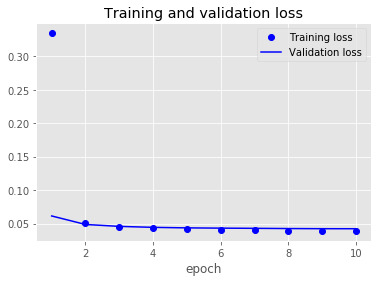

In [97]:
plot_training_history(history)

In addition to the final result, we also want to see the intermediate results from hidden layers. Below is an example showing how to get outputs from a hidden layer, and visualize them on the reduced dimension of 2D by PCA. (**Please note that these codes and parameters cannot be simply copied and pasted for other questions; some adjustments need to be made**) 

In [40]:
FFNN=load_keras_model("model_FFNN")
def create_truncated_model_FFNN(trained_model):
    model=Sequential()
    model.add(Embedding(input_dim=n_words, output_dim=dim_embed, input_length=max_len))
    model.add(Dropout(drop_rate))
    # set weights of first few layers using the weights of trained model
    for i, layer in enumerate(model.layers):
        layer.set_weights(trained_model.layers[i].get_weights())
    model.compile(optimizer=optimizer, loss=loss, metrics=metrics)
    return model
truncated_model = create_truncated_model_FFNN(FFNN)
hidden_features = truncated_model.predict(X_te)

# flatten data
hidden_features=hidden_features.reshape(-1,50)
 
# find first two PCA components
pca = PCA(n_components=2)
pca_result = pca.fit_transform(hidden_features)
print('Variance explained by PCA: {}'.format(np.sum(pca.explained_variance_ratio_)))

Variance explained by PCA: 0.9430508575808875


In [41]:
# visualize hidden featurs on first two PCA components
# this plot only shows B-tags
def visualize_hidden_features(pca_result):
    color=['r', 'C1', 'y', 'C3', 'b', 'g', 'm', 'orange']
    category = np.argmax(y_te, axis=1)
    fig, ax = plt.subplots()
    fig.set_size_inches(6,6)    
    for cat in range(8):
        indices_B = np.where(category==cat)[0]
        #length=min(1000,len(indices_B))
        #indices_B=indices_B[:length]
        ax.scatter(pca_result[indices_B,0], pca_result[indices_B, 1], label=idx2tag[cat],s=2,color=color[cat],alpha=0.5)
        legend=ax.legend(markerscale=3)
        legend.get_frame().set_facecolor('w')  
    plt.show()

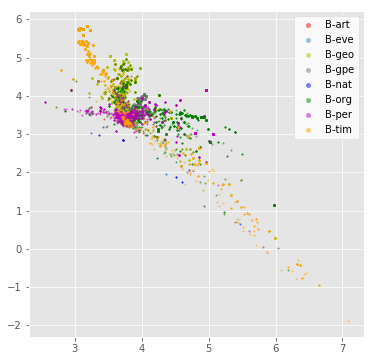

In [42]:
visualize_hidden_features(pca_result)

### Full function for other questions ###

In [108]:
def get_hidden_output_PCA(model,X_te,y_te,layer_index,out_dimension):
    output = backend.function([model.layers[0].input],[model.layers[layer_index].output])
    hidden_feature=np.array(output([X_te]))
    hidden_feature=hidden_feature.reshape(-1,out_dimension)
    
    pca = PCA(n_components=2)
    pca_result = pca.fit_transform(hidden_feature)
    print('Variance explained by PCA: {}'.format(np.sum(pca.explained_variance_ratio_)))
    return pca_result

In [119]:
def visualize_B_I(pca_result):
    color=['r', 'C1', 'y', 'C3', 'b', 'g', 'm', 'orange']
    category = np.argmax(y_te.reshape(-1,18), axis=1)
    fig, ax = plt.subplots(1,2) 
    fig.set_size_inches(12,6)
    for i in range(2):
        for cat in range(8*i,8*(i+1)):
            indices= np.where(category==cat)[0]
            ax[i].scatter(pca_result[indices,0], pca_result[indices, 1], label=idx2tag[cat],s=2,color=color[cat-8*i],alpha=0.5)
        legend=ax[i].legend(markerscale=3)
        legend.get_frame().set_facecolor('w') 
        ax[i].set_xlabel("first dimension")
        ax[i].set_ylabel("second dimension")
    fig.suptitle("visualization of hidden feature on reduced dimension by PCA")
    
    plt.show()

Variance explained by PCA: 0.9430507105675692


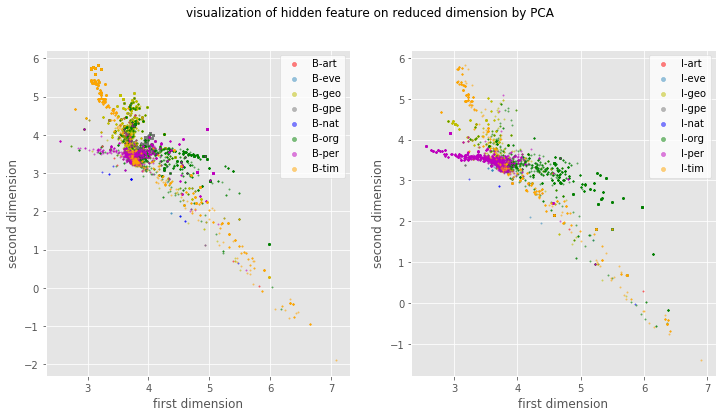

In [45]:
h=get_hidden_output_PCA(FFNN,X_te,y_te,1,50)
visualize_B_I(h)

### Model 3: RNN ###
<span class='sub-q'>**Question 2.3**</span>

(1) Set up a simple RNN model by stacking the following layers in sequence:
* an input layer
* a simple Embedding layer transforming integer words into vectors 
* a dropout layer to regularize the model
* a SimpleRNN layer 
* a TimeDistributed layer with an inner Dense layer which output dimensionality is equal to n_tag

(2) Compile the model

(3) Train the model and plot the training history

(4) Visualize outputs from SimpleRNN layer, one subplot for **B-tags** and one subplot for **I-tags**,comment on the patterns you observed.

For hyperparameters use those provided in Model 2

<div class='explication'> </div>

In [98]:
# clear session 
backend.clear_session()

# Define model
model=Sequential()
model.add(Embedding(input_dim=n_words, output_dim=dim_embed, input_length=max_len))
model.add(Dropout(drop_rate))
model.add(SimpleRNN(units=n_units, return_sequences=True))
model.add(TimeDistributed(Dense(n_tags, activation="softmax")))

# Compile model
model.compile(optimizer=optimizer, loss=loss, metrics=metrics)

# Train model
history = model.fit(X_tr, y_tr, batch_size=batch_size, epochs=epochs, 
                    validation_split=validation_split, verbose=verbose)

Train on 38846 samples, validate on 4317 samples
Epoch 1/10
38846/38846 [==============================] - 82s 2ms/step - loss: 0.0919 - acc: 0.9774 - val_loss: 0.0328 - val_acc: 0.9904
Epoch 2/10
38846/38846 [==============================] - 82s 2ms/step - loss: 0.0294 - acc: 0.9913 - val_loss: 0.0290 - val_acc: 0.9910
Epoch 3/10
38846/38846 [==============================] - 82s 2ms/step - loss: 0.0261 - acc: 0.9923 - val_loss: 0.0279 - val_acc: 0.9915
Epoch 4/10
38846/38846 [==============================] - 82s 2ms/step - loss: 0.0244 - acc: 0.9928 - val_loss: 0.0271 - val_acc: 0.9918
Epoch 5/10
38846/38846 [==============================] - 82s 2ms/step - loss: 0.0233 - acc: 0.9931 - val_loss: 0.0271 - val_acc: 0.9918
Epoch 6/10
38846/38846 [==============================] - 82s 2ms/step - loss: 0.0223 - acc: 0.9934 - val_loss: 0.0270 - val_acc: 0.9919
Epoch 7/10
38846/38846 [==============================] - 82s 2ms/step - loss: 0.0214 - acc: 0.9936 - val_loss: 0.0264 - val_acc:

In [ ]:
# save your mode ##
store_keras_model(model, 'model_RNN')

In [50]:
# run this cell to show your results #
print(model.summary())

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 104, 50)           1758950   
_________________________________________________________________
dropout_1 (Dropout)          (None, 104, 50)           0         
_________________________________________________________________
simple_rnn_1 (SimpleRNN)     (None, 104, 100)          15100     
_________________________________________________________________
time_distributed_1 (TimeDist (None, 104, 18)           1818      
Total params: 1,775,868
Trainable params: 1,775,868
Non-trainable params: 0
_________________________________________________________________
None


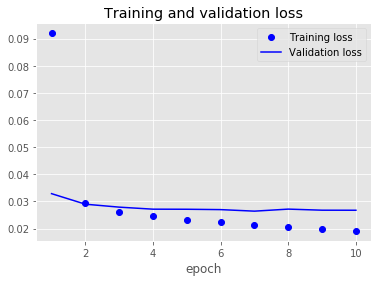

In [99]:
# run this cell to show your results #
plot_training_history(history)

Variance explained by PCA: 0.8460773803576209


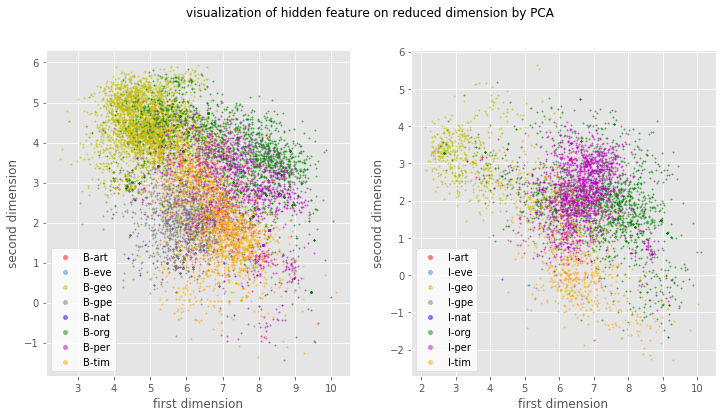

In [120]:
# visualization of hidden features
RNN=load_keras_model('model_RNN')
h=get_hidden_output_PCA(RNN,X_te,y_te,2,100)
visualize_B_I(h)

<div class='explication'> </div>

### Model 4: GRU ###

<span class='sub-q'>**Question 2.4**</span>


(1) Briefly explain what is GRU and how it is different from simple RNN

(2) build a GRU architecture by replacing the SimpleRNN cell with a GRU one. 

(3) Compile the model

(4) Train the model and plot the training history

(5) Visualize outputs from GRU layer, one subplot for **B-tags** and one subplot for **I-tags**, comment on the patterns you observed.

<div class='explication'> </div>

In [ ]:
backend.clear_session()

# Define model
model=Sequential()
model.add(Embedding(input_dim=n_words, output_dim=dim_embed, input_length=max_len))
model.add(Dropout(drop_rate))
model.add(GRU(units=n_units, return_sequences=True))
model.add(TimeDistributed(Dense(n_tags, activation="softmax")))

# Compile model
model.compile(optimizer=optimizer, loss=loss, metrics=metrics)

# Train model
history = model.fit(X_tr, y_tr, batch_size=batch_size, epochs=epochs, 
                    validation_split=validation_split, verbose=verbose)

In [ ]:
# save your model #
# store_keras_model(model, 'model_GRU')

In [48]:
# run this cell to show your results #
print(model.summary())

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 104, 50)           1758950   
_________________________________________________________________
dropout_1 (Dropout)          (None, 104, 50)           0         
_________________________________________________________________
gru_1 (GRU)                  (None, 104, 100)          45300     
_________________________________________________________________
time_distributed_1 (TimeDist (None, 104, 18)           1818      
Total params: 1,806,068
Trainable params: 1,806,068
Non-trainable params: 0
_________________________________________________________________
None


In [ ]:
# run this cell to show your results #
plot_training_history(history)

Variance explained by PCA: 0.8053728604777343


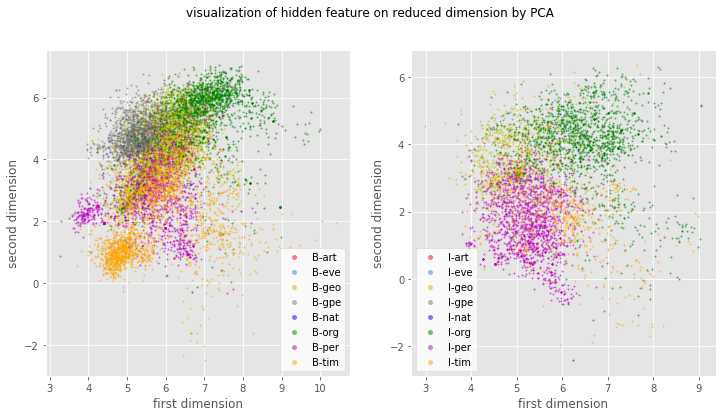

In [47]:
# visualization of hidden features
GRU=load_keras_model('model_GRU')
h=get_hidden_output_PCA(GRU,X_te,y_te,2,100)
visualize_B_I(h)

<div class='explication'> </div>

### Model 5: Bidirectional GRU ###
<span class='sub-q'>**Question 2.5**</span>


(1) Explain what is Bidirectional GRU and how it is different from GRU model above.

(2) Then build a bidirectional GRU by wrapping your GRU layer into a Bidirectional one

(3) Compile the model

(4) Train the model and plot the training history

(5) Visualize outputs from bidirectional GRU layer, one subplot for **B-tags** and one subplot for **I-tags**, comment on the patterns you observed.

<div class='explication'> </div>

In [ ]:
backend.clear_session()

# Define model
model=Sequential()
model.add(Embedding(input_dim=n_words, output_dim=dim_embed, input_length=max_len))
model.add(Dropout(drop_rate))
model.add(Bidirectional(GRU(units=n_units, return_sequences=True)))
model.add(TimeDistributed(Dense(n_tags, activation="softmax")))

# Compile model
model.compile(optimizer=optimizer, loss=loss, metrics=metrics)

# Train model
# history = model.fit(X_tr, y_tr, batch_size=batch_size, epochs=epochs, 
#                     validation_split=validation_split, verbose=verbose)

In [ ]:
# save your model #
# store_keras_model(model, 'model_BiGRU')

In [52]:
# run this cell to show your results #
print(model.summary())

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 104, 50)           1758950   
_________________________________________________________________
dropout_1 (Dropout)          (None, 104, 50)           0         
_________________________________________________________________
bidirectional_1 (Bidirection (None, 104, 200)          90600     
_________________________________________________________________
time_distributed_1 (TimeDist (None, 104, 18)           3618      
Total params: 1,853,168
Trainable params: 1,853,168
Non-trainable params: 0
_________________________________________________________________
None


In [ ]:
# run this cell to show your results #
plot_training_history(history)

Variance explained by PCA: 0.7845987327159935


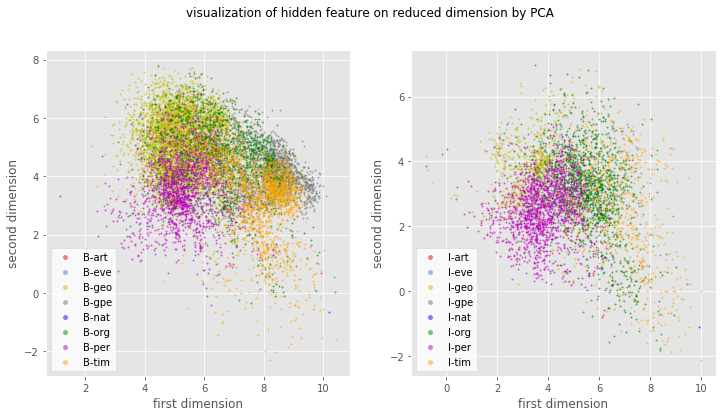

In [54]:
# visualization of hidden features
BiGRU=load_keras_model('model_BiGRU')
h=get_hidden_output_PCA(BiGRU,X_te,y_te,2,200)
visualize_B_I(h)

<div class='exercise'><b> Question 3: Analysis [40pt]</b></div>


<span class='sub-q'>**Question 3.1**</span>


For each model iteratively:

(1) Load the model using the given function ```load_keras_model```

(2) Apply the model to the test dataset

(3) Compute an F1 score for each ```Tag``` and store it 

(4) Plot the F1 score per Tag and per model making use of a grouped barplot.

(5) Briefly discuss the performance of each model

In [67]:
# Solution #
groups = []
model_names = ['baseline','model_FFNN','model_RNN', 'model_GRU', 'model_BiGRU']

for model_name in model_names:
    
    print('Processing model {}'.format(model_name))
    
    if model_name=='baseline':
        y_hat = baseline[X_te]
        f1_scores = f1_score(np.argmax(y_te,axis=-1).reshape(-1), 
                             y_hat.reshape(-1),average=None)
    else:
        model = load_keras_model(model_name)
        y_hat = model.predict(X_te, batch_size=10)

        f1_scores = f1_score(np.argmax(y_te,axis=-1).reshape(-1), 
                             np.argmax(y_hat,axis=-1).reshape(-1), 
                             average=None)
    
    groups.append(list(f1_scores))

group_labels = [key for key,value in tag2idx.items()]

Processing model baseline
Processing model model_FFNN
Processing model model_RNN
Processing model model_GRU
Processing model model_BiGRU


Text(0.5, 1.0, 'F1 scores')

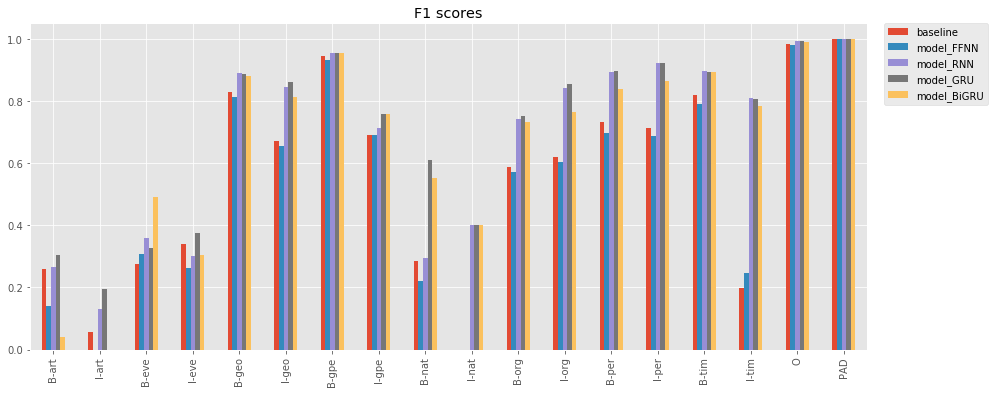

In [70]:
# solution #
df = pd.DataFrame(groups)
df.columns = group_labels
df.index = model_names

ordered_cols = ['B-art','I-art','B-eve','I-eve','B-geo','I-geo','B-gpe',
                'I-gpe','B-nat','I-nat','B-org','I-org','B-per','I-per',
                'B-tim','I-tim','O','PAD']
df = df[ordered_cols]

ax = df.T.plot.bar(figsize=(15,6))
patches, labels = ax.get_legend_handles_labels()
_ = ax.legend(patches, labels, loc=1, bbox_to_anchor=(1.15, 1.015))
ax.set_title("F1 scores")

<span class='sub-q'>**Question 3.2**</span>

(1) Which tags have the lowest f1 score? 

For instance, you may find from the plot above that the test accuracy on "B-art", and "I-art" are very low (just an example, your case maybe different). Here is an example when models failed to predict these tags right

<img src="./data/B_art.png" alt="drawing" width="600"/>


(2) Write functions to output another example in which the tags of the lowest accuracy was predicted wrong in a sentence (include both "B-xxx" and "I-xxx" tags). Store the results in a DataFrame (same format as the above example) and use styling functions below to print out your df.

In [55]:
def highlight_errors(s):
    is_max = s == s.y_true
    return ['' if v or key=='Word' else 'color: red' for key,v in is_max.iteritems()]

In [88]:
model_names = ['baseline','model_FFNN','model_RNN', 'model_GRU', 'model_BiGRU']
predictions = {}

for model_name in model_names:
    
    print('Processing model {}'.format(model_name))
    
    if model_name=='baseline':
        y_hat = baseline[X_te]
    else:
        model = load_keras_model(model_name)
        y_hat = model.predict(X_te, batch_size=10)
        y_hat = np.argmax(y_hat, axis=-1)
    
    predictions[model_name] = y_hat
    
predictions['y_true'] = np.argmax(y_te, axis=-1)

Processing model baseline
Processing model model_FFNN
Processing model model_RNN
Processing model model_GRU
Processing model model_BiGRU


In [89]:
sentences_selection = []
tag_of_interest = 'I-art'

for idx_sentence in range(y_te.shape[0]): # for each sentence in test set
    sentence = predictions['y_true'][idx_sentence,:]
    if tag2idx[tag_of_interest] in sentence: # if it contains the tag of interest
        # find indexes of tag of interest in sentence
        idx_tag = np.where(sentence==tag2idx[tag_of_interest])[0]
        # check where models of interest does not work
        if (predictions['y_true'][idx_sentence,idx_tag]!=predictions["model_BiGRU"][idx_sentence,idx_tag]).all() and \
            (predictions['y_true'][idx_sentence,idx_tag]!=predictions["model_FFNN"][idx_sentence,idx_tag]).all():
            sentences_selection.append(idx_sentence)

In [93]:
idx_selected_sentence = 1
df_sentence = pd.DataFrame(np.column_stack(([idx2word[i] for i in X_te[sentences_selection[idx_selected_sentence],:]],
                                            [idx2tag[i] for i in predictions['y_true'][sentences_selection[idx_selected_sentence],:]])))
df_sentence.columns = ['Word','y_true']

for m in ['baseline','model_FFNN','model_RNN', 'model_GRU', 'model_BiGRU'] :
    df_sentence[m]=[idx2tag[i] for i in predictions[m][sentences_selection[idx_selected_sentence],:]]
                                           
df_sentence = df_sentence[df_sentence.Word != 'ENDPAD']
df_sentence.style.apply(highlight_errors, axis=1)

,Word,y_true,baseline,model_FFNN,model_RNN,model_GRU,model_BiGRU
0,She,O,O,O,O,O,O
1,also,O,O,O,O,O,O
2,received,O,O,O,O,O,O
3,an,O,O,O,O,O,O
4,Academy,B-org,B-org,B-org,B-org,B-org,B-org
5,Award,I-org,I-org,I-org,I-org,I-org,I-org
6,and,O,O,O,O,O,O
7,an,O,O,O,O,O,O
8,NAACP,B-art,B-art,O,B-org,O,B-org
9,Image,I-art,I-art,O,I-org,I-org,I-org


<span class='sub-q'>**Question 3.3**</span>

(1) Choose one of the most promising models you have built, improve this model to achieve the f1 score higher than 0.8 for as many tags as possible ( you have lots of options here, e.g. data balancing, hyperparameter tuning, changing the structure of NN, a different optimizer, ... )

(2) Explain why you choose to change certain elements of the model and how effective those adjustments are.


In [14]:
from keras.layers.merge import Add
from keras.models import Model,Input
from keras.layers import Activation
from keras import backend as K
K.tensorflow_backend._get_available_gpus()

['/job:localhost/replica:0/task:0/device:GPU:0']

### unnecessarily long sentences for X

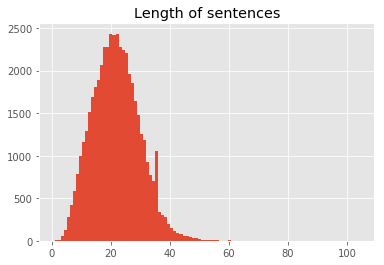

In [15]:
plt.hist([len(s) for s in sentences], bins=100)
plt.title("Length of sentences")
plt.show()

### re-padding to length=60

In [16]:
max_len=60
# Prepare predictors list of lists
X = [[word2idx[w[0]] for w in s] for s in sentences]
# Apply the keras pad_sequences function
X = pad_sequences(maxlen=max_len, sequences=X, padding="post", value=n_words-1)
y = [[tag2idx[w[1]] for w in s] for s in sentences]
# Apply the kera pas_sequences function
y = pad_sequences(maxlen=max_len, sequences=y, padding="post", value=tag2idx["PAD"])


### Check data imbalance

In [15]:
data.Tag.value_counts()

O        887908
B-geo     37644
B-tim     20333
B-org     20143
I-per     17251
B-per     16990
I-org     16784
B-gpe     15870
I-geo      7414
I-tim      6528
B-art       402
B-eve       308
I-art       297
I-eve       253
B-nat       201
I-gpe       198
I-nat        51
Name: Tag, dtype: int64

### Split train and test, stratify minority groups

In [17]:
def stratify_data(min_group):
    stratify_list=[]
    for tag in min_group:
        tag_set=set([int(str(v).split(" ")[-1]) for v in data[data.Tag==tag]["Sentence #"].values])
        stratify_list.append(tag_set)

    for i, tag_set in enumerate(stratify_list):
        stratify_list[i]=stratify_list[i]-stratify_list[i-1]

    union=set()
    for i in stratify_list:
        union=union|i
    dif=set(range(len(X)))-union

    train_idx=[]
    test_idx=[]
    for tag_set in stratify_list:
        tr,te=train_test_split(list(tag_set),test_size=0.1)
        train_idx+=(tr)
        test_idx+=(te)
    tr,te=train_test_split(list(dif),test_size=0.1)
    train_idx+=(tr)
    test_idx+=(te)

    X_tr=X[train_idx]
    X_te=X[test_idx]
    y_tr=y[train_idx]
    y_te=y[test_idx]
    y_tr=np.array([to_categorical(i, num_classes=n_tags) for i in y_tr])
    y_te=np.array([to_categorical(i, num_classes=n_tags) for i in y_te])
    
    return (X_tr,X_te,y_tr,y_te),union

### Boost sample weights

In [18]:
base=data.Tag.value_counts()[1]
def boost_weight(min_group,union):
    new_weight={}
    for tag in min_group:
        new_weight[tag]=base//data.Tag.value_counts()[tag]*10

    weight=[1 for i in range(len(X_tr))]
    for i,w in enumerate(weight):
        for tag in min_group:
            if i in union:
                weight[i]=(new_weight[tag])
                break
    weight=np.array(weight)
    return weight

In [19]:
target_group=["I-gpe","I-tim","I-geo"]
(X_tr,X_te,y_tr,y_te),union=stratify_data(target_group)
weight=boost_weight(target_group,union)

### custom metrics

In [20]:
def f1_tensor(y_true, y_pred):
    y_true=K.reshape(y_true,(-1,18))
    y_pred=K.reshape(y_pred,(-1,18))

    tp = K.sum(K.cast(y_true*y_pred, 'float'), axis=0)
    tn = K.sum(K.cast((1-y_true)*(1-y_pred), 'float'), axis=0)
    fp = K.sum(K.cast((1-y_true)*y_pred, 'float'), axis=0)
    fn = K.sum(K.cast(y_true*(1-y_pred), 'float'), axis=0)

    p = tp / (tp + fp + K.epsilon())
    r = tp / (tp + fn + K.epsilon())

    f1 = 2*p*r / (p+r+K.epsilon())
    f1 = tf.where(tf.is_nan(f1), tf.zeros_like(f1), f1)
    return f1

In [21]:
# mean f1 score
def f1(y_true, y_pred):
    f1=f1_tensor(y_true, y_pred)
    return K.mean(f1)

In [22]:
# number of tags with f1 score > 0.8
def ntag_80(y_true, y_pred):
    f1=f1_tensor(y_true, y_pred)
    return K.sum(K.cast((f1>0.8),'float'))

### custom loss function

In [23]:
# maximize number of tags with f1 score > 0.8
def f1_loss(y_true, y_pred):
    f1=f1_tensor(y_true, y_pred)
    # give up the hopeless tags
    mask=np.array([False,False,True,True,False,True,True,True,False,False,True,True,False,True,True,True,False,False])
    f1=tf.boolean_mask(f1, mask)
    return K.sum(K.clip((0.8-f1),0,0.8))

In [24]:
# improve overall f1 scores
def f1_loss_sum(y_true, y_pred):
    f1=f1_tensor(y_true, y_pred)
    return K.sum(1-f1)

### Model

(borrowed from https://github.com/ypwhs/baiduyun_deeplearning_competition, in essence the Bidirectional GRU)

In [30]:
# Define model
input_tensor = Input(shape=(max_len,))
x = input_tensor
x = Embedding(input_dim=n_words, output_dim=1024, input_length=max_len)(x)
x = Dense(n_units, kernel_initializer='he_uniform')(x)
x = BatchNormalization()(x)
x = Activation('relu')(x)
x = Dropout(0.2)(x)

gru_1 = GRU(n_units, return_sequences=True, kernel_initializer='he_uniform', name='gru1')(x)
gru_1b = GRU(n_units, return_sequences=True, kernel_initializer='he_uniform', 
             go_backwards=True, name='gru1_b')(x)
x = keras.layers.add([gru_1, gru_1b])

gru_2 = GRU(n_units, return_sequences=True, kernel_initializer='he_uniform', name='gru2')(x)
gru_2b = GRU(n_units, return_sequences=True, kernel_initializer='he_uniform', 
             go_backwards=True, name='gru2_b')(x)
x = keras.layers.concatenate([gru_2, gru_2b])

x = Dropout(0.2)(x)
x = Dense(n_tags, activation='softmax')(x)

model = Model(inputs=input_tensor, outputs=x)

### First, train a few epochs to reach a reasonable accuracy

In [ ]:
# Compile model
model.compile(optimizer=optimizer, loss=loss, metrics=['acc'])

# Train model
model.fit(X_tr, y_tr, batch_size=batch_size, epochs=epochs, 
        validation_split=validation_split,sample_weight=weight, verbose=1)

### Then train with f1_loss, and smaller learning rate

In [ ]:
# Compile model
model.compile(optimizer=keras.optimizers.RMSprop(lr=0.0001),loss=[f1_loss], metrics=[ntag_80,f1])

# Train model
model.fit(X_tr, y_tr, batch_size=batch_size, epochs=epochs, 
        validation_split=validation_split,sample_weight=weight, verbose=1)

###  Results after many more epochs...

In [39]:
model=load_keras_model('model_Merge_11')

In [40]:
y_hat = model.predict(X_te, batch_size=10)

f1_scores = f1_score(np.argmax(y_te,axis=-1).reshape(-1), 
                     np.argmax(y_hat,axis=-1).reshape(-1), 
                     average=None)

/usr/share/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


In [41]:
print("Number of tags with f1 score higher than 0.8: ")
print(sum(f1_scores>0.8))

Number of tags with f1 score higher than 0.8: 
11


Text(0.5, 1.0, 'F1 scores')

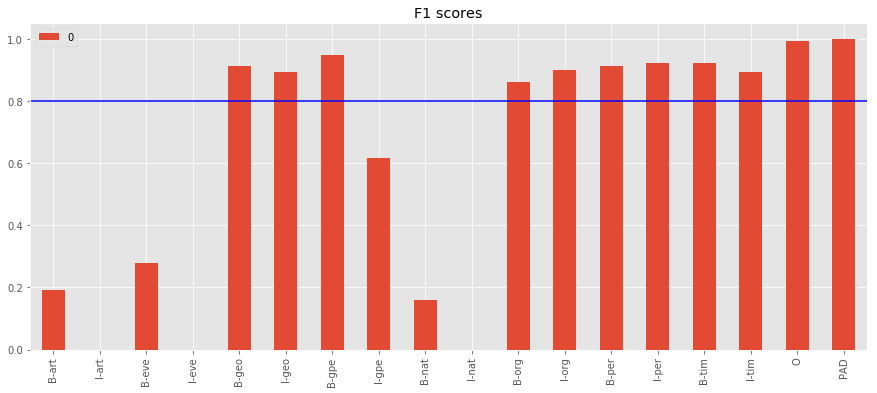

In [46]:
labels = [key for key,value in tag2idx.items()]
df = pd.DataFrame(f1_scores).T
df.columns = labels

ordered_cols = ['B-art','I-art','B-eve','I-eve','B-geo','I-geo','B-gpe',
                'I-gpe','B-nat','I-nat','B-org','I-org','B-per','I-per',
                'B-tim','I-tim','O','PAD']
df = df[ordered_cols]

ax = df.T.plot.bar(figsize=(15,6))
ax.hlines(0.8,-1,18,color='b')
ax.set_title("F1 scores")

### If you want to increase overall f1 scores of all classes (instead of having more tags > 0.8), stratify and boost weights of minority groups, and use the loss function "f1_loss_sum" for training.